# **[EIT] Earnest Insight Toolkit Demo**




## **I. Introduction**

### **DOI**:
https://doi.org/10.1145/3626252.3630838

### **Abstract**:
Today’s rapidly evolving educational landscape prioritizes active
student engagement. Classrooms at scale face particular challenges
in fostering meaningful interactions between students and course
content. In this study, we introduce EIT (Earnest Insight Toolkit),
a tool designed to assess students’ engagement within interactive lecture participation exercises—particularly in the context of large-
scale hybrid classrooms. We use EIT to conduct a comprehensive assessment of student responses to interactive lecture poll questions.

Our objective with EIT is to equip educators with valuable means of
identifying at-risk students for enhancing intervention and support
strategies and measuring student engagement with course content.

### **Pipeline Diagram and Requisities**:

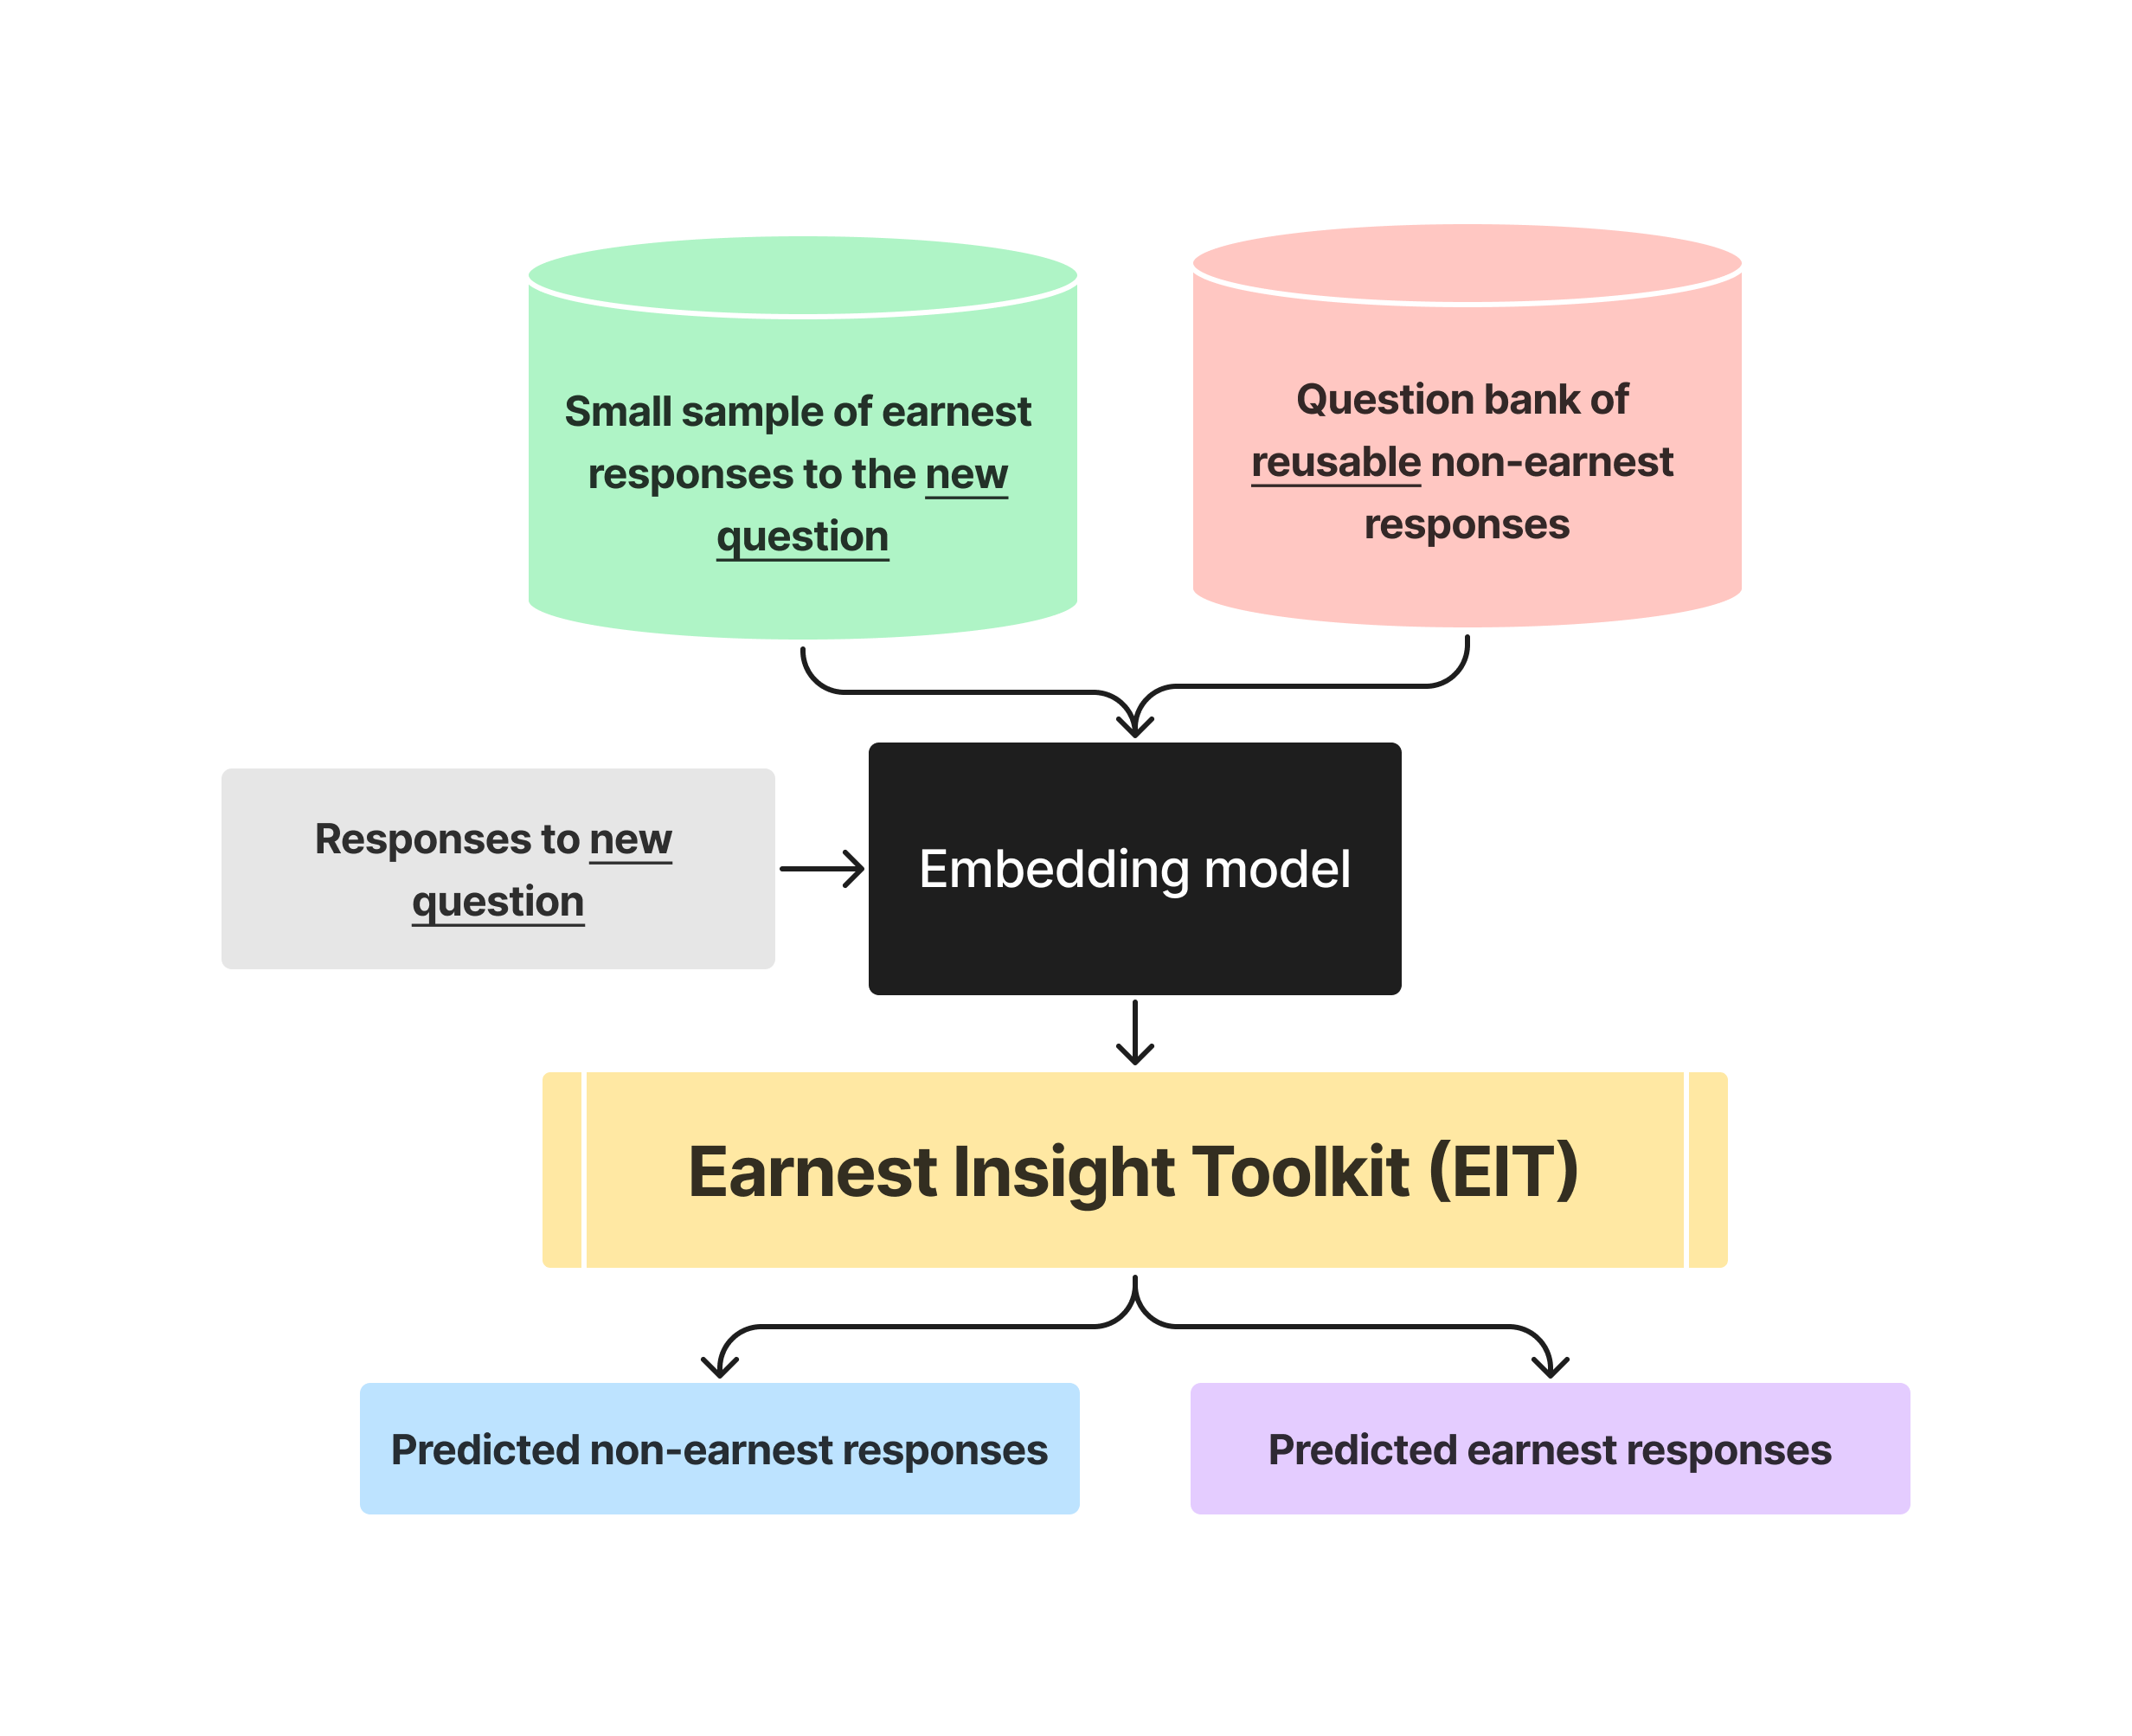

## **II. Setup**

Installing and importing the required libraries for the demo/tool.

In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

import warnings
warnings.filterwarnings('ignore')

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"

## **III. Loading data**

For the purpose of this demo, we are utilizing dummy responses and evaluations. You can substitute this file with real responses and evaluations following the same format. Download the CSV file from this GitHub repository and assign the file path in the cell below.

In [ ]:
# Mount Drive
# Run this cell if you uploaded the files from GitHub to your drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the File "[EIT] Dummy Slido Responses.csv"
# Edit below for the correct file path

data_path = 'YOUR PATH'

labeled_data = pd.read_csv(data_path)
labeled_data.head()

,Poll Question,Poll Option,Combined
0,What is the difference between L1 and L2 loss?,a 1 vs 2,1
1,What is the difference between L1 and L2 loss?,lol dunno,1
2,What is the difference between L1 and L2 loss?,h,1
3,What is the difference between L1 and L2 loss?,good q,1
4,What is the difference between L1 and L2 loss?,loss,1


## **IV. Exploratory Data Analysis**

We can now load the embedding model and embed poll responses (vector representations).

After embedding poll responses, we can visualize them by projecting the corresponding vector representations (embeddings) into a lower-dimensional space using t-Distributed Stochastic Neighbor Embedding (t-SNE). Following that, we cluster the responses using K-means.

In [ ]:
# Load Model

model = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Generate Embeddings

embeddings = model.encode(list(labeled_data["Poll Option"]))
labeled_data['Embeddings'] = list(np.array([np.array(embedding) for embedding in embeddings]))
labeled_data.head()

,Poll Question,Poll Option,Combined,Embeddings
0,What is the difference between L1 and L2 loss?,a 1 vs 2,1,"[0.020618748, -0.0393782, -0.015169326, -0.089..."
1,What is the difference between L1 and L2 loss?,lol dunno,1,"[-0.008785696, -0.064602226, 0.076876916, -0.0..."
2,What is the difference between L1 and L2 loss?,h,1,"[0.03500438, -0.034861322, -0.042209867, -0.06..."
3,What is the difference between L1 and L2 loss?,good q,1,"[0.025411915, -0.014223175, 0.028406281, 0.015..."
4,What is the difference between L1 and L2 loss?,loss,1,"[0.013624399, -0.0048437333, -0.006664612, 0.0..."


In [ ]:
# Project Embeddings Using TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=123)
embeddings_2d = tsne.fit_transform(embeddings)
labeled_data['2D Embeddings'] = list(embeddings_2d)
labeled_data.head()

,Poll Question,Poll Option,Combined,Embeddings,2D Embeddings
0,What is the difference between L1 and L2 loss?,a 1 vs 2,1,"[0.020618748, -0.0393782, -0.015169326, -0.089...","[59.7982, 37.209793]"
1,What is the difference between L1 and L2 loss?,lol dunno,1,"[-0.008785696, -0.064602226, 0.076876916, -0.0...","[72.406685, 115.30383]"
2,What is the difference between L1 and L2 loss?,h,1,"[0.03500438, -0.034861322, -0.042209867, -0.06...","[54.573566, 79.78659]"
3,What is the difference between L1 and L2 loss?,good q,1,"[0.025411915, -0.014223175, 0.028406281, 0.015...","[35.874786, 102.794914]"
4,What is the difference between L1 and L2 loss?,loss,1,"[0.013624399, -0.0048437333, -0.006664612, 0.0...","[92.53739, 54.535213]"


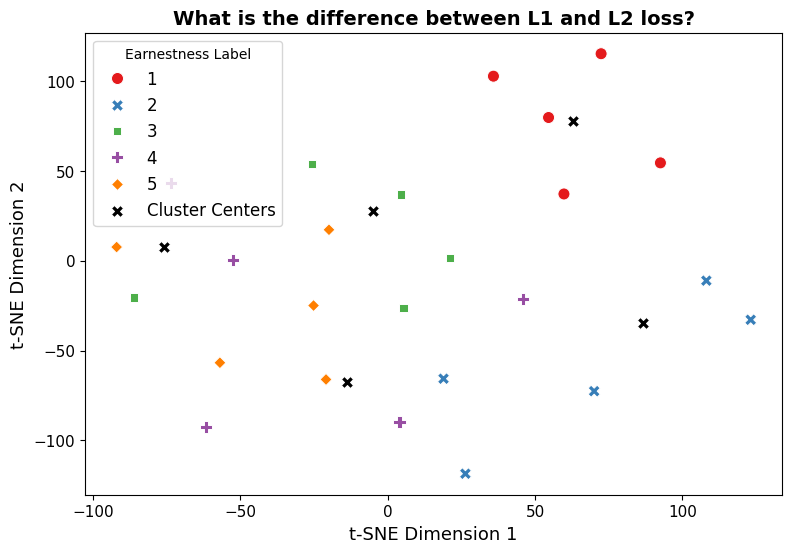

In [ ]:
# Visualize Clusters

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=123, n_init='auto')
clusters = kmeans.fit_predict(labeled_data['2D Embeddings'].tolist())
cluster_labels = clusters.tolist()

plt.figure(figsize=(9, 6))

embeddings_x = [coord[0] for coord in labeled_data['2D Embeddings']]
embeddings_y = [coord[1] for coord in labeled_data['2D Embeddings']]
plot_df = pd.DataFrame({'t-SNE Dim 1': embeddings_x,
                        't-SNE Dim 2': embeddings_y,
                        'Label': labeled_data['Combined']})

sns.scatterplot(data=plot_df, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='Label', palette='Set1', style='Label', s=75)

sns.scatterplot(x=kmeans.cluster_centers_[:, 0],
                y=kmeans.cluster_centers_[:, 1],
                marker='X',
                color='black',
                s=75,
                label='Cluster Centers')

plt.title('What is the difference between L1 and L2 loss?', size=14, weight='bold')
plt.xlabel('t-SNE Dimension 1', size=13)
plt.ylabel('t-SNE Dimension 2', size=13)
plt.xticks(size=11)
plt.yticks(size=11)
plt.legend(title='Earnestness Label', fontsize=12, title_fontsize=10);

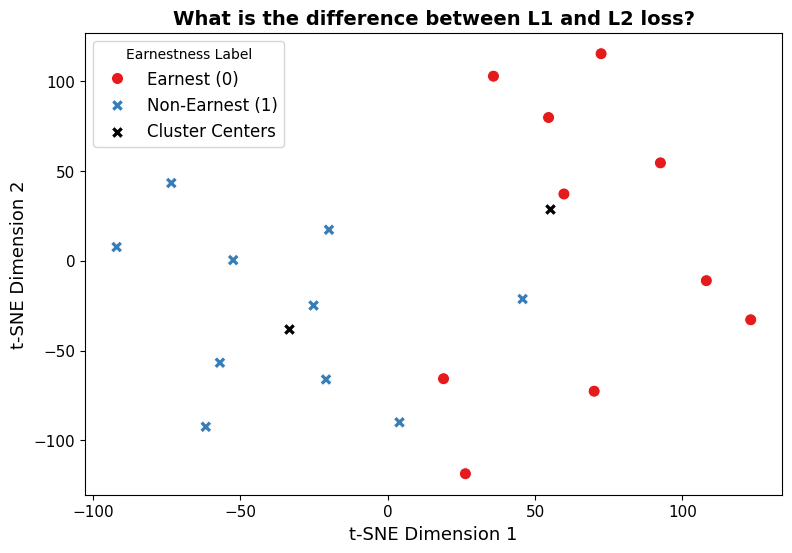

In [ ]:
# Filter Neutral Responses and Group Responses into 2 Categories: Earnest (4-5) and Non-earnest (1-2)

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=123, n_init='auto')
clusters = kmeans.fit_predict(labeled_data['2D Embeddings'].tolist())
cluster_labels = clusters.tolist()

plt.figure(figsize=(9, 6))

embeddings_x = [coord[0] for coord in labeled_data['2D Embeddings']]
embeddings_y = [coord[1] for coord in labeled_data['2D Embeddings']]
plot_df = pd.DataFrame({'t-SNE Dim 1': embeddings_x,
                        't-SNE Dim 2': embeddings_y,
                        'Label': labeled_data['Combined']})

# Removing Neutral Responses
plot_df = plot_df[plot_df['Label'] != 3]

# Grouping the Remaining Responses into Earnest and Non-earnest Categories
plot_df['Label'] = [0 if label < 3 else 1 for label in plot_df['Label']]
plot_df['Label'] = plot_df['Label'].map({1:'Non-Earnest (1)', 0:'Earnest (0)'})

# Plot scatterplot
sns.scatterplot(data=plot_df, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='Label', palette='Set1', style='Label', s=75)

sns.scatterplot(x=kmeans.cluster_centers_[:, 0],
                y=kmeans.cluster_centers_[:, 1],
                marker='X',
                color='black',
                s=75,
                label='Cluster Centers')

plt.title('What is the difference between L1 and L2 loss?', size=14, weight='bold')
plt.xlabel('t-SNE Dimension 1', size=13)
plt.ylabel('t-SNE Dimension 2', size=13)
plt.xticks(size=11)
plt.yticks(size=11)
plt.legend(title='Earnestness Label', fontsize=12, title_fontsize=10);

## **V. Earnest Insight Toolkit Modeling**

Now, we can use a nonparametric model KNN to do binary classification.

In [ ]:
def execute_eit(data, question, n_neighbors=5):
  """
  Function to generate Earnest Insight Toolkit (EIT) results.

  Parameters:
  - data: DataFrame containing the dataset.
  - question: The specific poll question to analyze.
  - n_neighbors: Number of neighbors for the KNN classifier.

  Returns:
  - accuracy: Mean accuracy of the KNN classifier.
  - recall: Recall score of the KNN classifier.
  """

  # Filter the data based on the poll question
  data_for_question = data[data['Poll Question'] == question]

  # Exclude neutrality, and split into two groups -- Non-earnest (<=2) and Earnest (>=4)
  filtered_data = data_for_question[(data_for_question['Combined'] <= 2) | (data_for_question['Combined'] >=4)]

  # Convert to binary labels (1: Non-earnest, 0: Earnest)
  filtered_data['Combined'] = [1 if x <= 2 else 0 for x in filtered_data['Combined'].tolist()]

  # Extract embeddings and labels
  embeddings = np.array([np.array(embedding) for embedding in filtered_data['Embeddings']])
  embedding_labels = np.concatenate([embeddings, np.array(filtered_data['Combined'])[:, None]], axis=1)

  # Initialize KNN classifier and compute mean accuracy using cross-validation
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
  accuracy = cross_val_score(estimator=knn_classifier,
                           X=embedding_labels[:, :-1],
                           y=embedding_labels[:, -1]).mean()

  # Make predictions using cross-validation
  predicted_labels = cross_val_predict(estimator=knn_classifier, X=embedding_labels[:, :-1], y=embedding_labels[:, -1])
  recall = recall_score(embedding_labels[:, -1], predicted_labels)

  return accuracy, recall

Here, we change the number of neighbors in the KNN algorithm and report the corresponding accuracy and recall scores.

In [ ]:
# Example with changing neighbors for EIT's KNN

n_s = range(1, 10, 2)
accuracies, recalls = [], []

for n in n_s:
  accuracy, recall = execute_eit(labeled_data, 'What is the difference between L1 and L2 loss?', n_neighbors=n)
  accuracies.append(accuracy)
  recalls.append(recall)

pd.DataFrame({'n': n_s,
              'Accuracy': accuracies,
              'Recall': recalls})

,n,Accuracy,Recall
0,1,0.80,0.7
1,3,0.75,0.6
2,5,0.80,0.6
3,7,0.80,0.6
4,9,0.80,0.6


We can also upload non-earnest responses from other questions (for the purposes of this demo, the responses are not real student responses).

In [ ]:
# Path to the file "[EIT] Non-earnest Responses Bank"
# Edit below for the correct file path

non_earnest_path = 'YOUR PATH'

non_earnest = pd.read_csv(non_earnest_path)
non_earnest.head()

,Non-earnest responses
0,yes
1,no
2,:)
3,))
4,.


In [ ]:
def execute_eit_with_non_earnest_prop(data, question, non_earnest_bank, prop_non_earnest, n_neighbors=5):
  """
  Function to execute Earnest Insight Toolkit (EIT) with a proportion of non-earnest responses and a non-earnest response bank.

  Parameters:
  - data: DataFrame containing the dataset.
  - question: The specific poll question to analyze.
  - non_earnest_bank: DataFrame containing non-earnest responses.
  - prop_non_earnest: Proportion of non-earnest responses to add to the training data.
  - n_neighbors: Number of neighbors for the KNN classifier.

  Returns:
  - Dictionary containing accuracy and recall scores for training and testing data.
    """

  # Filter the data based on the poll question
  data_for_question = data[data['Poll Question'] == question]

  # Exclude neutrality, and split into two groups -- Non-earnest (<=2) and Earnest (>=4)
  filtered_data = data_for_question[(data_for_question['Combined'] <= 2) | (data_for_question['Combined'] >=4)]

  # Convert to binary labels (1: Non-earnest, 0: Earnest)
  filtered_data['Combined'] = [1 if x <= 2 else 0 for x in filtered_data['Combined'].tolist()]

  # Extract embeddings and labels
  embeddings = np.array([np.array(embedding) for embedding in filtered_data['Embeddings']])
  embedding_labels = np.concatenate([embeddings, np.array(filtered_data['Combined'])[:, None]], axis=1)

  # Split data into training and testing sets
  train, test = train_test_split(embedding_labels, shuffle=True, test_size=0.2)

  # Embed non-earnest responses and add to the training data if prop_non_earnest is specified
  if prop_non_earnest:
    non_earnest_responses = non_earnest_bank.sample(int(len(non_earnest_bank) * prop_non_earnest), random_state=123)
    non_earnest_embeddings = model.encode(list(non_earnest_responses.iloc[0]))
    non_earnest_embeddings = np.array([np.array(embedding) for embedding in non_earnest_embeddings])
    non_earnest_embeddings = np.concatenate([non_earnest_embeddings, np.zeros((non_earnest_embeddings.shape[0], 1))], axis=1)
    train = np.concatenate([train, non_earnest_embeddings], axis=0)

  # Initialize and train KNN classifier
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn_classifier.fit(X=train[:, :-1], y=train[:, -1])

  # Predict labels for training and testing data
  predicted_train = knn_classifier.predict(X=train[:, :-1])
  predicted_test = knn_classifier.predict(X=test[:, :-1])

  # Compute accuracy and recall scores
  accuracy_train = accuracy_score(y_true=train[:, -1], y_pred=predicted_train)
  recall_train = recall_score(y_true=train[:, -1], y_pred=predicted_train)
  accuracy_test = accuracy_score(y_true=test[:, -1], y_pred=predicted_test)
  recall_test = recall_score(y_true=test[:, -1], y_pred=predicted_test)

  return {"train": (accuracy_train, recall_train),
          "test": (accuracy_test, recall_test)}

In [ ]:
# Example for changing the proportion of non-earnest responses

test_accuracies, test_recalls = [], []
proportions = np.arange(0, 1.01, 0.1)

for prop in proportions:
  results = execute_eit_with_non_earnest_prop(labeled_data, 'What is the difference between L1 and L2 loss?', non_earnest, prop)
  test_accuracies.append(results['test'][0])
  test_recalls.append(results['test'][1])

pd.DataFrame({'Proportion': proportions,
              'Accuracy': test_accuracies,
              'Recall': test_recalls})

,Proportion,Accuracy,Recall
0,0.0,1.00,0.000000
1,0.1,0.75,0.666667
2,0.2,0.75,0.750000
3,0.3,1.00,1.000000
4,0.4,1.00,1.000000
5,0.5,0.75,0.000000
6,0.6,0.25,0.000000
7,0.7,0.75,0.000000
8,0.8,0.75,0.000000
9,0.9,0.50,0.333333
